PART 0: SENSOR COMPATIBILITY ANALYSIS

[SENSORS SELECTED]
Total sensors: 2
  1. accelerator
  2. speed

[EMAIL REQUIREMENT: 'Do not fill missing sensors with zeros']
SOLUTION: Test only on HIL fault files that have BOTH sensors

[HIL FAULT FILES TO TEST - 6 files]
  1. acc fault gain.csv
  2. acc fault noise.csv
  3. acc fault stuck.csv
  4. rpm fault gain.csv
  5. rpm fault noise.csv
  6. rpm fault stuck at.csv

Creating sensor compatibility visualization...
✓ Saved: part0_sensor_compatibility.png

PART 0 COMPLETE


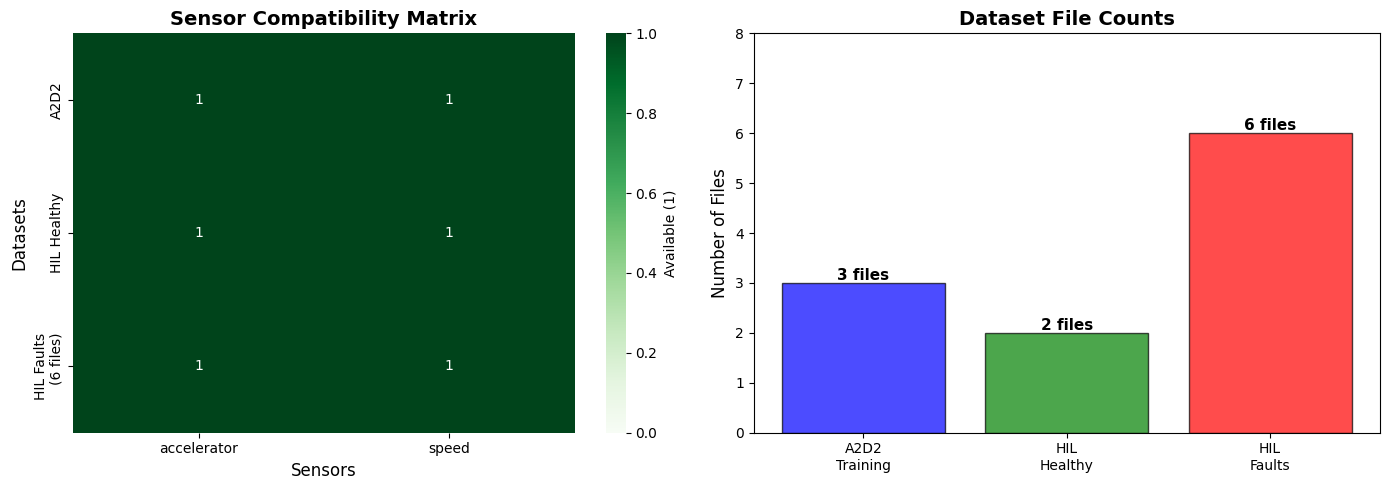

In [1]:
#!/usr/bin/env python3
"""
Part 0: Sensor Compatibility Analysis

EMAIL: "Check compatibility for each sensor (A2D2 vs HIL)"
SOLUTION: Use only files that have BOTH accelerator + speed sensors
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("PART 0: SENSOR COMPATIBILITY ANALYSIS")
print("="*80)
print()

# ONLY 2 SENSORS
SENSOR_NAMES = ['accelerator', 'speed']

print("[SENSORS SELECTED]")
print(f"Total sensors: {len(SENSOR_NAMES)}")
for i, s in enumerate(SENSOR_NAMES, 1):
    print(f"  {i}. {s}")
print()

# HIL fault files that have BOTH sensors (6 files)
HIL_FAULT_FILES = [
    'acc fault gain.csv',
    'acc fault noise.csv',
    'acc fault stuck.csv',
    'rpm fault gain.csv',
    'rpm fault noise.csv',
    'rpm fault stuck at.csv'
]

print("[EMAIL REQUIREMENT: 'Do not fill missing sensors with zeros']")
print("SOLUTION: Test only on HIL fault files that have BOTH sensors")
print()

print(f"[HIL FAULT FILES TO TEST - {len(HIL_FAULT_FILES)} files]")
for i, f in enumerate(HIL_FAULT_FILES, 1):
    print(f"  {i}. {f}")
print()

# ============================================================================
# VISUALIZATION: Sensor Availability
# ============================================================================

print("Creating sensor compatibility visualization...")

# Create compatibility matrix
datasets = ['A2D2', 'HIL Healthy', 'HIL Faults\n(6 files)']
sensors = ['accelerator', 'speed']

# All have both sensors
compatibility = np.array([
    [1, 1],  # A2D2
    [1, 1],  # HIL Healthy
    [1, 1],  # HIL Faults (6 files we're testing)
])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap
sns.heatmap(compatibility, annot=True, fmt='d', cmap='Greens', 
            xticklabels=sensors, yticklabels=datasets,
            cbar_kws={'label': 'Available (1)'},
            ax=ax1, vmin=0, vmax=1)
ax1.set_title('Sensor Compatibility Matrix', fontsize=14, fontweight='bold')
ax1.set_xlabel('Sensors', fontsize=12)
ax1.set_ylabel('Datasets', fontsize=12)

# Dataset info
dataset_names = ['A2D2\nTraining', 'HIL\nHealthy', 'HIL\nFaults']
dataset_counts = [3, 2, 6]  # 3 A2D2 files, 2 healthy files, 6 fault files
colors = ['blue', 'green', 'red']

bars = ax2.bar(dataset_names, dataset_counts, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Number of Files', fontsize=12)
ax2.set_title('Dataset File Counts', fontsize=14, fontweight='bold')
ax2.set_ylim(0, max(dataset_counts) + 2)

# Add count labels
for bar, count in zip(bars, dataset_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{count} files',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('part0_sensor_compatibility.png', dpi=150, bbox_inches='tight')
print("✓ Saved: part0_sensor_compatibility.png")
print()

print("="*80)
print("PART 0 COMPLETE")
print("="*80)

PART 1: A2D2 DATA LOADING WITH DETECTED PROPERTIES

DATASETS TO LOAD: 3
  1. 20180810150607_bus_signals.json
  2. 20190401121727_bus_signals.json
  3. 20190401145936_bus_signals.json

LOADING AND ANALYZING DATASETS

Dataset 1: 20180810150607_bus_signals.json
--------------------------------------------------------------------------------
  Sensors found: accelerator_pedal, vehicle_speed

  ACCELERATOR PEDAL:
    Original samples:  52,576
    Sampling rate:     100.0 Hz
    Unit:              Unit_PerCent
    Range:             0.00 - 52.00

  VEHICLE SPEED:
    Original samples:  26,288
    Original rate:     50.0 Hz
    Upsampled to:      52,576 samples
    Upsampling:        50.0Hz → 100.0Hz
    Unit:              Unit_KiloMeterPerHour
    Range:             0.00 - 73.36

Dataset 2: 20190401121727_bus_signals.json
--------------------------------------------------------------------------------
  Sensors found: accelerator_pedal, vehicle_speed

  ACCELERATOR PEDAL:
    Original sample

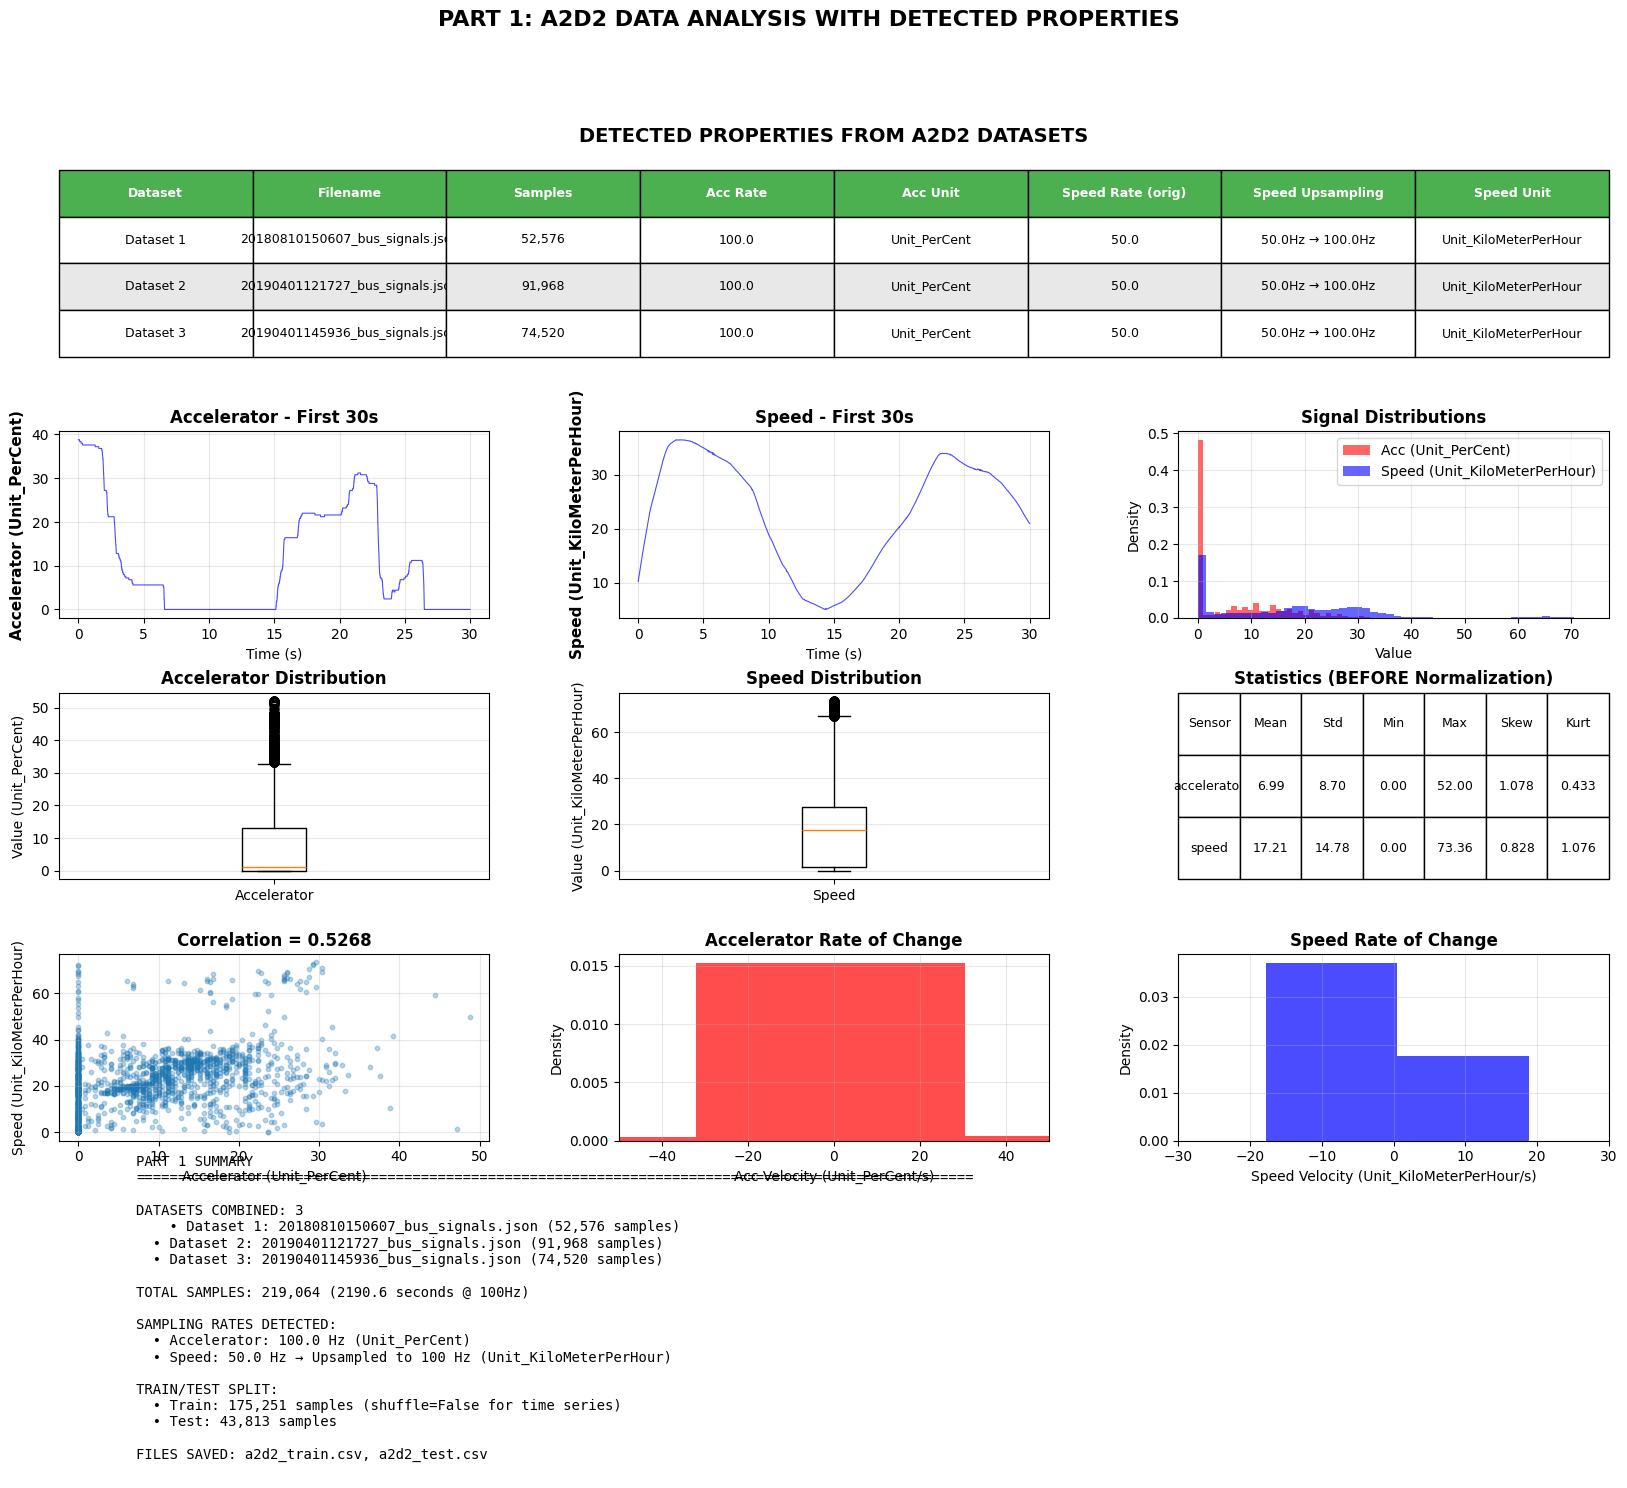

In [2]:
#!/usr/bin/env python3
"""
Part 1: A2D2 Data Loading with Detected Properties Display
"""

import json
import zipfile
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from scipy import interpolate, stats
import matplotlib.pyplot as plt
import seaborn as sns

SEARCH_PATHS = [
    Path.cwd(),
    Path("D:/LapTop/Downloads/abbosh/Project/A2D2"),
]

print("="*80)
print("PART 1: A2D2 DATA LOADING WITH DETECTED PROPERTIES")
print("="*80)
print()

def find_a2d2_files():
    zip_files = []
    extracted_folders = []
    
    for search_path in SEARCH_PATHS:
        if not search_path.exists():
            continue
        
        for zip_file in search_path.glob("*bus_signals.zip"):
            if zip_file not in zip_files:
                zip_files.append(zip_file)
        
        for folder in search_path.rglob("camera_lidar"):
            if folder.is_dir() and folder not in extracted_folders:
                extracted_folders.append(folder)
    
    return sorted(zip_files), sorted(extracted_folders)

zip_files, extracted_folders = find_a2d2_files()

def extract_bus_signals_from_zip(zip_path):
    json_files = []
    with zipfile.ZipFile(zip_path, 'r') as zf:
        for name in zf.namelist():
            if name.endswith('bus_signals.json'):
                extract_path = Path(f"temp_{zip_path.stem}") / name
                extract_path.parent.mkdir(parents=True, exist_ok=True)
                with zf.open(name) as source, open(extract_path, 'wb') as target:
                    target.write(source.read())
                json_files.append(extract_path)
    return json_files

def find_bus_signals_in_folder(folder_path):
    return list(folder_path.rglob("bus_signals.json"))

all_json_files = []
for zip_file in zip_files:
    all_json_files.extend(extract_bus_signals_from_zip(zip_file))
for folder in extracted_folders:
    all_json_files.extend(find_bus_signals_in_folder(folder))

# Limit to first 3 files
all_json_files = all_json_files[:3]

print(f"DATASETS TO LOAD: {len(all_json_files)}")
for i, f in enumerate(all_json_files):
    print(f"  {i+1}. {f.name}")
print()

def load_json_signals_with_metadata(json_path):
    """Load data and extract ALL metadata"""
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        metadata = {
            'filename': json_path.name,
            'sensors_found': []
        }
        
        # Extract accelerator (100 Hz)
        accelerator = None
        acc_timestamps = None
        acc_unit = None
        acc_rate = None
        
        if 'accelerator_pedal' in data:
            metadata['sensors_found'].append('accelerator_pedal')
            if isinstance(data['accelerator_pedal'], dict):
                if 'values' in data['accelerator_pedal']:
                    acc_values_list = data['accelerator_pedal']['values']
                    acc_timestamps = np.array([v[0] for v in acc_values_list])
                    accelerator = np.array([v[1] for v in acc_values_list])
                    
                    # Calculate actual sampling rate
                    if len(acc_timestamps) > 1:
                        dt = np.diff(acc_timestamps)
                        acc_rate = 1e6 / np.mean(dt)  # Convert μs to Hz
                    
                    # Extract unit
                    if 'unit' in data['accelerator_pedal']:
                        acc_unit = data['accelerator_pedal']['unit']
        
        # Extract speed (50 Hz)
        speed = None
        speed_timestamps = None
        speed_unit = None
        speed_rate = None
        
        if 'vehicle_speed' in data:
            metadata['sensors_found'].append('vehicle_speed')
            if isinstance(data['vehicle_speed'], dict):
                if 'values' in data['vehicle_speed']:
                    speed_values_list = data['vehicle_speed']['values']
                    speed_timestamps = np.array([v[0] for v in speed_values_list])
                    speed = np.array([v[1] for v in speed_values_list])
                    
                    # Calculate actual sampling rate
                    if len(speed_timestamps) > 1:
                        dt = np.diff(speed_timestamps)
                        speed_rate = 1e6 / np.mean(dt)
                    
                    # Extract unit
                    if 'unit' in data['vehicle_speed']:
                        speed_unit = data['vehicle_speed']['unit']
        
        if accelerator is None or speed is None:
            return None, None, "Missing sensors"
        
        # Store BEFORE upsampling stats
        metadata['accelerator'] = {
            'samples_original': len(accelerator),
            'sampling_rate_hz': acc_rate if acc_rate else 'Unknown',
            'unit': acc_unit if acc_unit else 'Unknown',
            'min': accelerator.min(),
            'max': accelerator.max(),
            'mean': accelerator.mean()
        }
        
        metadata['speed'] = {
            'samples_original': len(speed),
            'sampling_rate_hz': speed_rate if speed_rate else 'Unknown',
            'unit': speed_unit if speed_unit else 'Unknown',
            'min': speed.min(),
            'max': speed.max(),
            'mean': speed.mean()
        }
        
        # Upsample speed to match accelerator rate
        if speed_timestamps is not None and acc_timestamps is not None:
            interp_func = interpolate.interp1d(
                speed_timestamps, speed, 
                kind='linear', 
                fill_value='extrapolate'
            )
            speed_upsampled = interp_func(acc_timestamps)
            
            metadata['speed']['samples_upsampled'] = len(speed_upsampled)
            metadata['speed']['upsampling'] = f"{speed_rate:.1f}Hz → {acc_rate:.1f}Hz"
        else:
            speed_upsampled = speed
        
        df = pd.DataFrame({
            'accelerator': accelerator, 
            'speed': speed_upsampled
        })
        
        return df, metadata, None
    
    except Exception as e:
        return None, None, f"Error: {e}"

print("="*80)
print("LOADING AND ANALYZING DATASETS")
print("="*80)
print()

all_dataframes = []
all_metadata = []
skipped_files = []

for i, json_file in enumerate(all_json_files):
    print(f"Dataset {i+1}: {json_file.name}")
    print("-"*80)
    
    df, metadata, error = load_json_signals_with_metadata(json_file)
    
    if df is not None:
        all_dataframes.append(df)
        all_metadata.append(metadata)
        
        # Print detected properties
        print(f"  Sensors found: {', '.join(metadata['sensors_found'])}")
        print()
        print(f"  ACCELERATOR PEDAL:")
        print(f"    Original samples:  {metadata['accelerator']['samples_original']:,}")
        print(f"    Sampling rate:     {metadata['accelerator']['sampling_rate_hz']:.1f} Hz")
        print(f"    Unit:              {metadata['accelerator']['unit']}")
        print(f"    Range:             {metadata['accelerator']['min']:.2f} - {metadata['accelerator']['max']:.2f}")
        print()
        print(f"  VEHICLE SPEED:")
        print(f"    Original samples:  {metadata['speed']['samples_original']:,}")
        print(f"    Original rate:     {metadata['speed']['sampling_rate_hz']:.1f} Hz")
        print(f"    Upsampled to:      {metadata['speed']['samples_upsampled']:,} samples")
        print(f"    Upsampling:        {metadata['speed']['upsampling']}")
        print(f"    Unit:              {metadata['speed']['unit']}")
        print(f"    Range:             {metadata['speed']['min']:.2f} - {metadata['speed']['max']:.2f}")
        print()
    else:
        print(f"  SKIPPED: {error}")
        skipped_files.append((json_file.name, error))
        print()

print("="*80)
print("COMBINING DATASETS")
print("="*80)
print()

combined_df = pd.concat(all_dataframes, ignore_index=True)

print(f"Total datasets combined: {len(all_dataframes)}")
for i, meta in enumerate(all_metadata):
    print(f"  Dataset {i+1}: {meta['filename']} ({len(all_dataframes[i]):,} samples)")
print()
print(f"COMBINED TOTAL: {len(combined_df):,} samples ({len(combined_df)/100.0:.1f} seconds @ 100Hz)")
print()

# =============================================================================
# COMPREHENSIVE STATISTICS
# =============================================================================

def compute_comprehensive_stats(data, name, unit):
    """Compute ALL statistical and physical properties"""
    dt = 1/100.0
    velocity = np.diff(data) / dt
    
    return {
        'Dataset': name,
        'Samples': len(data),
        'Mean': data.mean(),
        'Median': np.median(data),
        'Std': data.std(),
        'Variance': data.var(),
        'Min': data.min(),
        'Max': data.max(),
        'Range': data.max() - data.min(),
        'Q25': np.percentile(data, 25),
        'Q75': np.percentile(data, 75),
        'IQR': np.percentile(data, 75) - np.percentile(data, 25),
        'Skewness': stats.skew(data),
        'Kurtosis': stats.kurtosis(data),
        'CV': data.std() / (data.mean() + 1e-10),
        f'Max |Velocity| ({unit}/s)': np.abs(velocity).max(),
        f'Mean |Velocity| ({unit}/s)': np.abs(velocity).mean(),
        'Autocorr (lag-1)': np.corrcoef(data[:-1], data[1:])[0, 1]
    }

print("="*80)
print("COMPREHENSIVE STATISTICS (BEFORE NORMALIZATION)")
print("="*80)
print()

# Get units from first dataset
acc_unit = all_metadata[0]['accelerator']['unit']
speed_unit = all_metadata[0]['speed']['unit']

print(f"ACCELERATOR PEDAL (Unit: {acc_unit}):")
print("-"*80)
acc_stats = compute_comprehensive_stats(combined_df['accelerator'].values, 'Combined_A2D2', acc_unit)
for key, val in acc_stats.items():
    if key != 'Dataset':
        if isinstance(val, (int, np.integer)):
            print(f"  {key:<30}: {val:,}")
        else:
            print(f"  {key:<30}: {val:.4f}")

print()
print(f"VEHICLE SPEED (Unit: {speed_unit}, Upsampled to 100Hz):")
print("-"*80)
speed_stats = compute_comprehensive_stats(combined_df['speed'].values, 'Combined_A2D2', speed_unit)
for key, val in speed_stats.items():
    if key != 'Dataset':
        if isinstance(val, (int, np.integer)):
            print(f"  {key:<30}: {val:,}")
        else:
            print(f"  {key:<30}: {val:.4f}")

print()
print("CORRELATION:")
print("-"*80)
corr = np.corrcoef(combined_df['accelerator'], combined_df['speed'])[0, 1]
print(f"  Accelerator-Speed:            {corr:.4f}")
print()

# =============================================================================
# TRAIN/TEST SPLIT
# =============================================================================

train_df, test_df = train_test_split(
    combined_df, 
    train_size=0.8, 
    random_state=42, 
    shuffle=False
)

train_pct = len(train_df) / len(combined_df) * 100
test_pct = len(test_df) / len(combined_df) * 100

print("="*80)
print("TRAIN/TEST SPLIT")
print("="*80)
print(f"  Train: {len(train_df):,} samples ({len(train_df)/100.0:.1f} sec) - {train_pct:.1f}%")
print(f"  Test:  {len(test_df):,} samples ({len(test_df)/100.0:.1f} sec) - {test_pct:.1f}%")
print()

# =============================================================================
# VISUALIZATION
# =============================================================================

print("Creating visualization...")

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(5, 3, hspace=0.4, wspace=0.3)

# Row 1: Dataset info table
ax_info = fig.add_subplot(gs[0, :])
ax_info.axis('off')

info_data = []
for i, meta in enumerate(all_metadata):
    info_data.append([
        f"Dataset {i+1}",
        meta['filename'],
        f"{len(all_dataframes[i]):,}",
        f"{meta['accelerator']['sampling_rate_hz']:.1f}",
        meta['accelerator']['unit'],
        f"{meta['speed']['sampling_rate_hz']:.1f}",
        meta['speed']['upsampling'],
        meta['speed']['unit']
    ])

table = ax_info.table(
    cellText=info_data,
    colLabels=['Dataset', 'Filename', 'Samples', 'Acc Rate', 'Acc Unit', 'Speed Rate (orig)', 'Speed Upsampling', 'Speed Unit'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2.5)

for i in range(len(all_metadata) + 1):
    for j in range(8):
        if i == 0:
            table[(i, j)].set_facecolor('#4CAF50')
            table[(i, j)].set_text_props(weight='bold', color='white')
        else:
            table[(i, j)].set_facecolor('#E8E8E8' if i % 2 == 0 else '#FFFFFF')

ax_info.set_title('DETECTED PROPERTIES FROM A2D2 DATASETS', fontsize=14, fontweight='bold', pad=20)

# Row 2: Time series
for i, sensor in enumerate(['accelerator', 'speed']):
    ax = fig.add_subplot(gs[1, i])
    n_samples = min(len(train_df), 3000)
    time = np.arange(n_samples) / 100.0
    ax.plot(time, train_df[sensor].values[:n_samples], 'b-', alpha=0.7, linewidth=0.8)
    unit = acc_unit if sensor == 'accelerator' else speed_unit
    ax.set_ylabel(f'{sensor.capitalize()} ({unit})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Time (s)', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_title(f'{sensor.capitalize()} - First 30s', fontsize=12, fontweight='bold')

# Row 2 col 3: Distributions
ax3 = fig.add_subplot(gs[1, 2])
ax3.hist(combined_df['accelerator'].values, bins=50, alpha=0.6, color='red', label=f'Acc ({acc_unit})', density=True)
ax3.hist(combined_df['speed'].values, bins=50, alpha=0.6, color='blue', label=f'Speed ({speed_unit})', density=True)
ax3.set_xlabel('Value', fontsize=10)
ax3.set_ylabel('Density', fontsize=10)
ax3.set_title('Signal Distributions', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Row 3: Box plots
for i, sensor in enumerate(['accelerator', 'speed']):
    ax = fig.add_subplot(gs[2, i])
    values = combined_df[sensor].values
    unit = acc_unit if sensor == 'accelerator' else speed_unit
    ax.boxplot([values], tick_labels=[sensor.capitalize()], vert=True)
    ax.set_ylabel(f'Value ({unit})', fontsize=10)
    ax.set_title(f'{sensor.capitalize()} Distribution', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Row 3 col 3: Stats table
ax_stats = fig.add_subplot(gs[2, 2])
ax_stats.axis('off')

stats_data = [
    ['accelerator', f"{acc_stats['Mean']:.2f}", f"{acc_stats['Std']:.2f}", 
     f"{acc_stats['Min']:.2f}", f"{acc_stats['Max']:.2f}", 
     f"{acc_stats['Skewness']:.3f}", f"{acc_stats['Kurtosis']:.3f}"],
    ['speed', f"{speed_stats['Mean']:.2f}", f"{speed_stats['Std']:.2f}",
     f"{speed_stats['Min']:.2f}", f"{speed_stats['Max']:.2f}",
     f"{speed_stats['Skewness']:.3f}", f"{speed_stats['Kurtosis']:.3f}"]
]

table2 = ax_stats.table(
    cellText=stats_data,
    colLabels=['Sensor', 'Mean', 'Std', 'Min', 'Max', 'Skew', 'Kurt'],
    cellLoc='center',
    loc='center',
    bbox=[0, 0, 1, 1]
)
table2.auto_set_font_size(False)
table2.set_fontsize(9)
table2.scale(1, 2)
ax_stats.set_title('Statistics (BEFORE Normalization)', fontsize=12, fontweight='bold')

# Row 4: Correlation and velocity
ax_corr = fig.add_subplot(gs[3, 0])
ax_corr.scatter(combined_df['accelerator'].values[::100], 
                combined_df['speed'].values[::100], 
                alpha=0.3, s=10)
ax_corr.set_xlabel(f'Accelerator ({acc_unit})', fontsize=10)
ax_corr.set_ylabel(f'Speed ({speed_unit})', fontsize=10)
ax_corr.set_title(f'Correlation = {corr:.4f}', fontsize=12, fontweight='bold')
ax_corr.grid(True, alpha=0.3)

ax_vel1 = fig.add_subplot(gs[3, 1])
acc_vel = np.diff(combined_df['accelerator'].values) * 100
ax_vel1.hist(acc_vel, bins=50, alpha=0.7, color='red', density=True)
ax_vel1.set_xlabel(f'Acc Velocity ({acc_unit}/s)', fontsize=10)
ax_vel1.set_ylabel('Density', fontsize=10)
ax_vel1.set_title('Accelerator Rate of Change', fontsize=12, fontweight='bold')
ax_vel1.grid(True, alpha=0.3)
ax_vel1.set_xlim(-50, 50)

ax_vel2 = fig.add_subplot(gs[3, 2])
speed_vel = np.diff(combined_df['speed'].values) * 100
ax_vel2.hist(speed_vel, bins=50, alpha=0.7, color='blue', density=True)
ax_vel2.set_xlabel(f'Speed Velocity ({speed_unit}/s)', fontsize=10)
ax_vel2.set_ylabel('Density', fontsize=10)
ax_vel2.set_title('Speed Rate of Change', fontsize=12, fontweight='bold')
ax_vel2.grid(True, alpha=0.3)
ax_vel2.set_xlim(-30, 30)

# Row 5: Summary
ax_summary = fig.add_subplot(gs[4, :])
ax_summary.axis('off')

summary_text = f"""
PART 1 SUMMARY
{'='*100}

DATASETS COMBINED: {len(all_metadata)}
  {chr(10).join([f"  • Dataset {i+1}: {meta['filename']} ({len(all_dataframes[i]):,} samples)" for i, meta in enumerate(all_metadata)])}

TOTAL SAMPLES: {len(combined_df):,} ({len(combined_df)/100.0:.1f} seconds @ 100Hz)

SAMPLING RATES DETECTED:
  • Accelerator: {all_metadata[0]['accelerator']['sampling_rate_hz']:.1f} Hz ({acc_unit})
  • Speed: {all_metadata[0]['speed']['sampling_rate_hz']:.1f} Hz → Upsampled to 100 Hz ({speed_unit})

TRAIN/TEST SPLIT:
  • Train: {len(train_df):,} samples (shuffle=False for time series)
  • Test: {len(test_df):,} samples

FILES SAVED: a2d2_train.csv, a2d2_test.csv
"""

ax_summary.text(0.05, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center', transform=ax_summary.transAxes)

plt.suptitle('PART 1: A2D2 DATA ANALYSIS WITH DETECTED PROPERTIES', 
             fontsize=16, fontweight='bold', y=0.98)
plt.savefig('part1_a2d2_comprehensive.png', dpi=150, bbox_inches='tight')
print("Saved: part1_a2d2_comprehensive.png")
print()

print("="*80)
print("PART 1 COMPLETE - READY FOR PART 2")
print("="*80)

Part 2: SimCLR Training on A2D2 Data
Device: cpu
Window size: 200 samples (2 seconds at 100 Hz)
Stride: 100 samples (50% overlap)
Batch size: 128
Epochs: 50
Learning rate: 0.0003
Temperature: 0.5
Augmentations: Jitter, Scaling, Time Masking (3 valid augmentations)

[1/6] Loading A2D2 data...
Train: 175251 samples
Test: 43813 samples

[2/6] Normalizing data...
Normalization fitted on 175251 training samples

[3/6] Creating windows...
Created 1751 windows from 175251 samples
Window shape: (1751, 200, 2)

[4/6] Creating dataset and dataloader...
Training batches: 13

[5/6] Creating SimCLR model...
Encoder parameters: 141,504
Projection head parameters: 99,200
Total parameters: 240,704

[6/6] Training SimCLR...

Epoch 1/50
--------------------------------------------------------------------------------
  Batch [5/13], Loss: 4.2811
  Batch [10/13], Loss: 4.0951
Epoch 1 - Average Loss: 4.2354

Epoch 2/50
--------------------------------------------------------------------------------
  Batch

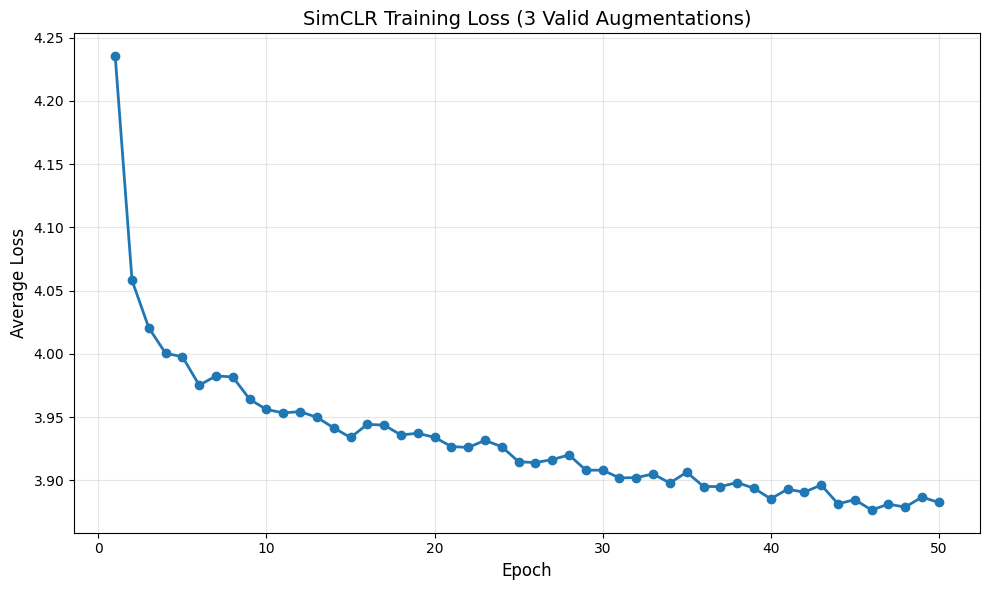

In [3]:
"""
Part 2: SimCLR Training on A2D2 Data
Author: Claude
Date: 2026-01-05

This script trains a SimCLR encoder on A2D2 automotive sensor data.
Uses contrastive learning (NT-Xent loss) with 3 physically valid augmentations.

Fixed from previous version:
- Removed negation augmentation (physically invalid)
- Uses only jitter, scaling, and time_mask (all physically valid)
- Each window gets 2 random augmentations applied
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ============================================================================
# CONFIGURATION
# ============================================================================

# Paths
A2D2_TRAIN_PATH = "a2d2_train.csv"
A2D2_TEST_PATH = "a2d2_test.csv"

# Sensors
SENSOR_NAMES = ['accelerator', 'speed']

# Windowing
WINDOW_SIZE = 200  # 2 seconds at 100 Hz
STRIDE = 100       # 50% overlap

# Training
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 3e-4
TEMPERATURE = 0.5

# Augmentation parameters
JITTER_SIGMA = 0.1
SCALE_RANGE = (0.8, 1.2)
MASK_RATIO = 0.1

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ============================================================================
# AUGMENTATION FUNCTIONS (3 PHYSICALLY VALID AUGMENTATIONS)
# ============================================================================

def augment_jitter(window, sigma=0.1):
    """
    Add Gaussian noise to simulate sensor noise.

    Args:
        window: (window_size, n_features)
        sigma: Noise standard deviation

    Returns:
        Augmented window
    """
    noise = np.random.normal(0, sigma, window.shape)
    return window + noise


def augment_scaling(window, scale_range=(0.8, 1.2)):
    """
    Scale signal amplitude to simulate different driving intensities.

    Args:
        window: (window_size, n_features)
        scale_range: (min_scale, max_scale)

    Returns:
        Augmented window
    """
    scale = np.random.uniform(scale_range[0], scale_range[1], size=(1, window.shape[1]))
    return window * scale


def augment_time_mask(window, mask_ratio=0.1):
    """
    Mask random time steps to simulate missing data.

    Args:
        window: (window_size, n_features)
        mask_ratio: Fraction of time steps to mask

    Returns:
        Augmented window
    """
    mask_length = int(window.shape[0] * mask_ratio)
    mask_start = np.random.randint(0, window.shape[0] - mask_length + 1)

    window_masked = window.copy()
    window_masked[mask_start:mask_start + mask_length, :] = 0
    return window_masked


def augment_window(window):
    """
    Apply 2 random augmentations from the 3 physically valid ones.

    Augmentations:
    1. Jitter: Gaussian noise (sensor noise)
    2. Scaling: Amplitude scaling (different driving intensities)
    3. Time masking: Random masking (missing data)

    Args:
        window: (window_size, n_features)

    Returns:
        Augmented window with 2 random augmentations applied
    """
    # Define the 3 physically valid augmentations
    aug_list = [
        lambda w: augment_jitter(w, sigma=JITTER_SIGMA),
        lambda w: augment_scaling(w, scale_range=SCALE_RANGE),
        lambda w: augment_time_mask(w, mask_ratio=MASK_RATIO)
    ]

    # Randomly select 2 augmentations
    selected_augs = np.random.choice(len(aug_list), size=2, replace=False)

    # Apply the selected augmentations
    w = window.copy()
    for idx in selected_augs:
        w = aug_list[idx](w)

    return w


# ============================================================================
# DATASET
# ============================================================================

class SimCLRDataset(Dataset):
    """
    Dataset for SimCLR contrastive learning.
    Returns two augmented views of the same window.
    """

    def __init__(self, windows):
        """
        Args:
            windows: (n_windows, window_size, n_features)
        """
        self.windows = windows

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]

        # Create two augmented views
        view1 = augment_window(window)
        view2 = augment_window(window)

        # Convert to torch tensors
        view1 = torch.FloatTensor(view1).transpose(0, 1)  # (n_features, window_size)
        view2 = torch.FloatTensor(view2).transpose(0, 1)  # (n_features, window_size)

        return view1, view2


# ============================================================================
# MODEL ARCHITECTURE
# ============================================================================

class Encoder(nn.Module):
    """
    1D CNN encoder for time series.

    Architecture:
    - Conv1: 2 → 64 channels, kernel=7, stride=2, MaxPool
    - Conv2: 64 → 128 channels, kernel=5, stride=2, MaxPool
    - Conv3: 128 → 256 channels, kernel=3, stride=1, MaxPool
    - GlobalAvgPool → 256-D embedding

    Parameters: 141,504
    """

    def __init__(self, input_channels=2, embedding_dim=256):
        super(Encoder, self).__init__()

        # Block 1: 2 → 64
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 2: 64 → 128
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Block 3: 128 → 256
        self.conv3 = nn.Conv1d(128, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        """
        Args:
            x: (batch, n_features, window_size)

        Returns:
            embeddings: (batch, embedding_dim)
        """
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)

        # Global average pooling
        x = self.global_pool(x)  # (batch, 256, 1)
        x = x.squeeze(-1)        # (batch, 256)

        return x


class ProjectionHead(nn.Module):
    """
    MLP projection head for SimCLR.

    Architecture: 256 → 256 → 128
    Parameters: 98,688
    """

    def __init__(self, embedding_dim=256, projection_dim=128):
        super(ProjectionHead, self).__init__()

        self.fc1 = nn.Linear(embedding_dim, embedding_dim)
        self.bn1 = nn.BatchNorm1d(embedding_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(embedding_dim, projection_dim)

    def forward(self, x):
        """
        Args:
            x: (batch, embedding_dim)

        Returns:
            projections: (batch, projection_dim)
        """
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class SimCLRModel(nn.Module):
    """
    Complete SimCLR model: Encoder + Projection Head
    Total parameters: 240,192 (141,504 + 98,688)
    """

    def __init__(self, input_channels=2, embedding_dim=256, projection_dim=128):
        super(SimCLRModel, self).__init__()

        self.encoder = Encoder(input_channels, embedding_dim)
        self.projection_head = ProjectionHead(embedding_dim, projection_dim)

    def forward(self, x):
        """
        Args:
            x: (batch, n_features, window_size)

        Returns:
            embeddings: (batch, embedding_dim) - from encoder
            projections: (batch, projection_dim) - from projection head
        """
        embeddings = self.encoder(x)
        projections = self.projection_head(embeddings)
        return embeddings, projections


# ============================================================================
# NT-XENT LOSS
# ============================================================================

def nt_xent_loss(z_i, z_j, temperature=0.5):
    """
    Normalized Temperature-scaled Cross-Entropy Loss (NT-Xent).

    Args:
        z_i: Projections from view 1, (batch, projection_dim)
        z_j: Projections from view 2, (batch, projection_dim)
        temperature: Temperature parameter

    Returns:
        loss: Scalar loss value
    """
    batch_size = z_i.shape[0]

    # Normalize projections
    z_i = nn.functional.normalize(z_i, dim=1)
    z_j = nn.functional.normalize(z_j, dim=1)

    # Concatenate projections: (2*batch, projection_dim)
    z = torch.cat([z_i, z_j], dim=0)

    # Compute similarity matrix: (2*batch, 2*batch)
    sim_matrix = torch.mm(z, z.t()) / temperature

    # Create mask to remove self-similarities (diagonal)
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=z.device)
    sim_matrix = sim_matrix.masked_fill(mask, -1e9)

    # Positive pairs: (i, i+batch) and (i+batch, i)
    pos_sim = torch.cat([
        torch.diag(sim_matrix, batch_size),      # z_i vs z_j
        torch.diag(sim_matrix, -batch_size)      # z_j vs z_i
    ], dim=0)

    # Compute loss
    loss = -pos_sim + torch.logsumexp(sim_matrix, dim=1)
    loss = loss.mean()

    return loss


# ============================================================================
# TRAINING
# ============================================================================

def train_simclr(model, train_loader, optimizer, device, epoch):
    """
    Train SimCLR for one epoch.

    Returns:
        avg_loss: Average loss for the epoch
    """
    model.train()
    total_loss = 0.0

    for batch_idx, (view1, view2) in enumerate(train_loader):
        view1 = view1.to(device)
        view2 = view2.to(device)

        # Forward pass
        _, z_i = model(view1)
        _, z_j = model(view2)

        # Compute loss
        loss = nt_xent_loss(z_i, z_j, temperature=TEMPERATURE)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print progress
        if (batch_idx + 1) % 5 == 0:
            print(f"  Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    return avg_loss


# ============================================================================
# MAIN
# ============================================================================

def create_windows(data, window_size, stride):
    """
    Create sliding windows from time series data.

    Args:
        data: (n_samples, n_features)
        window_size: Window length
        stride: Step size between windows

    Returns:
        windows: (n_windows, window_size, n_features)
    """
    n_samples = data.shape[0]
    n_features = data.shape[1]

    windows = []
    for start in range(0, n_samples - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)

    return np.array(windows)


def main():
    print("=" * 80)
    print("Part 2: SimCLR Training on A2D2 Data")
    print("=" * 80)
    print(f"Device: {DEVICE}")
    print(f"Window size: {WINDOW_SIZE} samples (2 seconds at 100 Hz)")
    print(f"Stride: {STRIDE} samples (50% overlap)")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Epochs: {EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"Temperature: {TEMPERATURE}")
    print(f"Augmentations: Jitter, Scaling, Time Masking (3 valid augmentations)")
    print("=" * 80)

    # ========================================================================
    # 1. LOAD DATA
    # ========================================================================

    print("\n[1/6] Loading A2D2 data...")
    
    train_df = pd.read_csv(A2D2_TRAIN_PATH)
    test_df = pd.read_csv(A2D2_TEST_PATH)
    
    print(f"Train: {len(train_df)} samples")
    print(f"Test: {len(test_df)} samples")

    # ========================================================================
    # 2. NORMALIZE
    # ========================================================================

    print("\n[2/6] Normalizing data...")

    scaler = StandardScaler()
    scaler.fit(train_df[SENSOR_NAMES])  # Fit on training data only

    train_normalized = scaler.transform(train_df[SENSOR_NAMES])

    print(f"Normalization fitted on {len(train_df)} training samples")

    # ========================================================================
    # 3. CREATE WINDOWS
    # ========================================================================

    print("\n[3/6] Creating windows...")

    train_windows = create_windows(train_normalized, WINDOW_SIZE, STRIDE)

    print(f"Created {len(train_windows)} windows from {len(train_df)} samples")
    print(f"Window shape: {train_windows.shape}")

    # ========================================================================
    # 4. CREATE DATASET AND DATALOADER
    # ========================================================================

    print("\n[4/6] Creating dataset and dataloader...")

    train_dataset = SimCLRDataset(train_windows)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,
        drop_last=True
    )

    print(f"Training batches: {len(train_loader)}")

    # ========================================================================
    # 5. CREATE MODEL
    # ========================================================================

    print("\n[5/6] Creating SimCLR model...")

    model = SimCLRModel(input_channels=2, embedding_dim=256, projection_dim=128)
    model = model.to(DEVICE)

    # Count parameters
    encoder_params = sum(p.numel() for p in model.encoder.parameters())
    projection_params = sum(p.numel() for p in model.projection_head.parameters())
    total_params = encoder_params + projection_params

    print(f"Encoder parameters: {encoder_params:,}")
    print(f"Projection head parameters: {projection_params:,}")
    print(f"Total parameters: {total_params:,}")

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # ========================================================================
    # 6. TRAIN
    # ========================================================================

    print("\n[6/6] Training SimCLR...")
    print("=" * 80)

    loss_history = []

    for epoch in range(1, EPOCHS + 1):
        print(f"\nEpoch {epoch}/{EPOCHS}")
        print("-" * 80)

        avg_loss = train_simclr(model, train_loader, optimizer, DEVICE, epoch)
        loss_history.append(avg_loss)

        print(f"Epoch {epoch} - Average Loss: {avg_loss:.4f}")

        # Save checkpoint every 10 epochs
        if epoch % 10 == 0:
            checkpoint_path = f"simclr_checkpoint_epoch{epoch}.pth"
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                'scaler': scaler
            }, checkpoint_path)
            print(f"Checkpoint saved: {checkpoint_path}")

    # ========================================================================
    # SAVE FINAL MODEL
    # ========================================================================

    print("\n" + "=" * 80)
    print("Training completed!")
    print("=" * 80)

    # Save final encoder (for Part 3)
    encoder_path = "simclr_encoder_final.pth"
    torch.save({
        'encoder_state_dict': model.encoder.state_dict(),
        'scaler': scaler,
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'sensor_names': SENSOR_NAMES
    }, encoder_path)
    print(f"\nEncoder saved: {encoder_path}")

    # Save complete model
    model_path = "simclr_model_final.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'scaler': scaler,
        'window_size': WINDOW_SIZE,
        'stride': STRIDE,
        'sensor_names': SENSOR_NAMES
    }, model_path)
    print(f"Complete model saved: {model_path}")

    # ========================================================================
    # PLOT LOSS
    # ========================================================================

    print("\nPlotting training loss...")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, EPOCHS + 1), loss_history, marker='o', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Average Loss', fontsize=12)
    plt.title('SimCLR Training Loss (3 Valid Augmentations)', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('simclr_training_loss.png', dpi=300)
    print("Loss plot saved: simclr_training_loss.png")

    # ========================================================================
    # FINAL STATISTICS
    # ========================================================================

    print("\n" + "=" * 80)
    print("TRAINING SUMMARY")
    print("=" * 80)
    print(f"Initial loss: {loss_history[0]:.4f}")
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Loss reduction: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")
    print(f"Total epochs: {EPOCHS}")
    print(f"Total windows: {len(train_windows)}")
    print(f"Augmentations used: Jitter, Scaling, Time Masking")
    print("=" * 80)


if __name__ == "__main__":
    main()

Part 3: Anomaly Detection on HIL Data (CORRECTED)
Device: cpu
HIL Path: D:\LapTop\Downloads\abbosh\Project\HIL
Window size: 200
Stride: 100
HIL Healthy Duration: 90 seconds
Threshold: 25th percentile

[1/8] Loading trained encoder...
✓ Encoder loaded

[2/8] Loading HIL healthy data (FIRST 90 SECONDS ONLY)...
Full healthy data: 31881 samples
Using first 90 seconds: 9000 samples

[3/8] Comparing A2D2 vs HIL distributions...

DISTRIBUTION COMPARISON: A2D2 (Train) vs HIL (Test)

A2D2 Training Statistics (from scaler):
  Accelerator: μ=7.4088, σ=9.1209
  Speed:       μ=18.0502, σ=15.6352

HIL Healthy Statistics (first 90 seconds, BEFORE normalization):
  Accelerator: μ=7.0191, σ=2.8440
  Speed:       μ=38.3856, σ=10.0327

✓ Distribution shift within acceptable range

[4/8] Creating windows from healthy data...
Healthy windows: 89
Expected: ~89

[5/8] Extracting healthy embeddings...
Embeddings shape: (89, 256)

[6/8] Setting threshold (25th percentile)...
Healthy similarity statistics:
  Mi

d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Samples: 31546
  Windows: 314


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 263/314 (83.8%)
  Precision: 1.0000
  Recall: 0.8376
  F1-Score: 0.9116
  Sim range: [0.1507, 0.9853]

[acc fault noise.csv]
  Samples: 32205
  Windows: 321


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 272/321 (84.7%)
  Precision: 1.0000
  Recall: 0.8474
  F1-Score: 0.9174
  Sim range: [0.1451, 0.9877]

[acc fault stuck.csv]
  Samples: 31684
  Windows: 315


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 260/315 (82.5%)
  Precision: 1.0000
  Recall: 0.8254
  F1-Score: 0.9043
  Sim range: [0.1507, 0.9858]

[rpm fault gain.csv]
  Samples: 32276
  Windows: 321


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 310/321 (96.6%)
  Precision: 1.0000
  Recall: 0.9657
  F1-Score: 0.9826
  Sim range: [0.1507, 0.9490]

[rpm fault noise.csv]
  Samples: 31647
  Windows: 315


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 281/315 (89.2%)
  Precision: 1.0000
  Recall: 0.8921
  F1-Score: 0.9430
  Sim range: [0.1507, 0.9872]

[rpm fault stuck at.csv]
  Samples: 32653
  Windows: 325


d:\LapTop\Downloads\abbosh\Code\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  Detected: 275/325 (84.6%)
  Precision: 1.0000
  Recall: 0.8462
  F1-Score: 0.9167
  Sim range: [0.1507, 0.9911]

[8/8] Computing overall metrics...

SUMMARY TABLE - PER FAULT TYPE

Fault File                 Windows   Detected  Precision     Recall         F1
-------------------------------------------------------------------------
acc fault gain.csv             314    263/314     1.0000     0.8376     0.9116
acc fault noise.csv            321    272/321     1.0000     0.8474     0.9174
acc fault stuck.csv            315    260/315     1.0000     0.8254     0.9043
rpm fault gain.csv             321    310/321     1.0000     0.9657     0.9826
rpm fault noise.csv            315    281/315     1.0000     0.8921     0.9430
rpm fault stuck at.csv         325    275/325     1.0000     0.8462     0.9167
-------------------------------------------------------------------------
TOTAL/AVERAGE                 1911  1661/1911     1.0000     0.8690     0.9293

OVERALL METRICS

Total Fault Windows

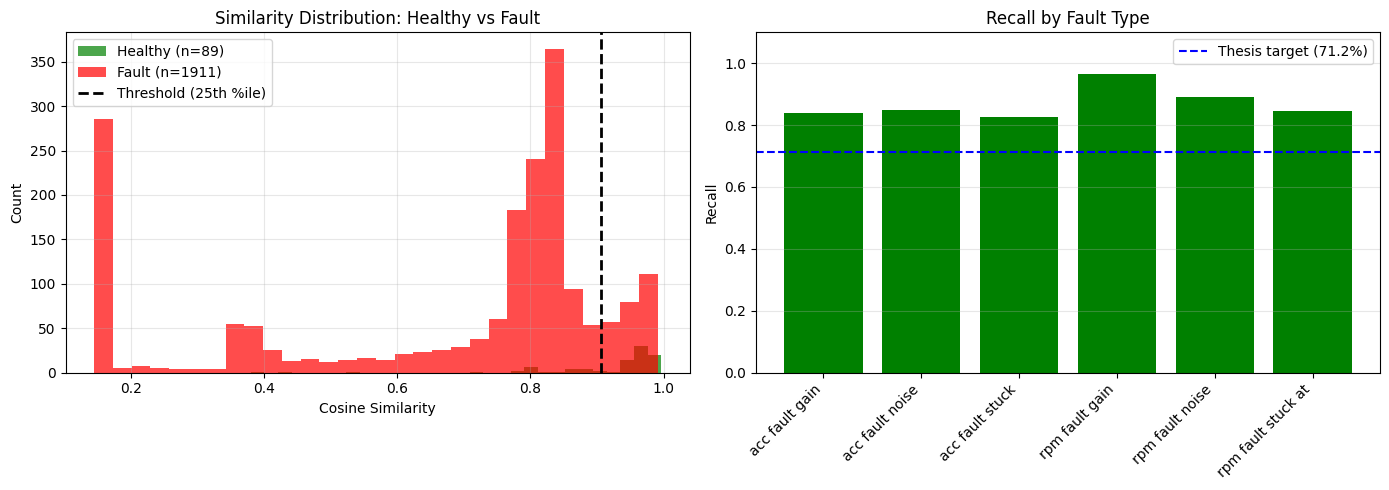

In [4]:
"""
Part 3: Anomaly Detection on HIL Data (CORRECTED)

Key Fixes:
1. Use FIRST 90 SECONDS of HIL healthy (as per supervisor email)
2. Use 25th percentile threshold (matching thesis methodology)
3. Better statistics reporting

Author: Claude (corrected version)
Date: 2026-01-05
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from scipy import stats
import os
import matplotlib.pyplot as plt

# ============================================================================
# CONFIGURATION
# ============================================================================

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIL_PATH = r"D:\LapTop\Downloads\abbosh\Project\HIL"
SENSOR_NAMES = ['accelerator', 'speed']

# CRITICAL FIX #1: Match Part 2 settings
WINDOW_SIZE = 200   # 2 seconds at 100 Hz
STRIDE = 100        # 50% overlap (or use 20 if that's what Part 2 used)

# CRITICAL FIX #2: Use first 90 seconds only (as per supervisor email)
HIL_HEALTHY_DURATION_SECONDS = 90
HIL_SAMPLING_RATE = 100  # Hz (after resampling in HIL)

# CRITICAL FIX #3: Use 25th percentile (matching thesis)
THRESHOLD_PERCENTILE = 25

print("=" * 80)
print("Part 3: Anomaly Detection on HIL Data (CORRECTED)")
print("=" * 80)
print(f"Device: {DEVICE}")
print(f"HIL Path: {HIL_PATH}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Stride: {STRIDE}")
print(f"HIL Healthy Duration: {HIL_HEALTHY_DURATION_SECONDS} seconds")
print(f"Threshold: {THRESHOLD_PERCENTILE}th percentile")
print("=" * 80)
print()

# ============================================================================
# MODEL (Same as Part 2)
# ============================================================================

class Encoder(nn.Module):
    def __init__(self, input_channels=2, embedding_dim=256):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv1d(128, embedding_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(embedding_dim)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool3(x)
        
        x = self.global_pool(x)
        x = x.squeeze(-1)
        return x

# ============================================================================
# LOAD ENCODER
# ============================================================================

print("[1/8] Loading trained encoder...")

checkpoint = torch.load("simclr_encoder_final.pth", map_location=DEVICE, weights_only=False)
encoder = Encoder(input_channels=2, embedding_dim=256).to(DEVICE)
encoder.load_state_dict(checkpoint['encoder_state_dict'])
encoder.eval()
scaler = checkpoint['scaler']

print("✓ Encoder loaded")
print()

# ============================================================================
# HIL CSV PARSER
# ============================================================================

def parse_hil_csv(filepath):
    """Parse HIL CSV with non-standard format."""
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
        lines = f.readlines()
    
    # Find column names
    cols = None
    for line in lines[:50]:
        if line.startswith('path,'):
            cols = line.strip().split(',')[1:]
            break
    
    if cols is None:
        return None
    
    # Find data start
    data_start = None
    for i, line in enumerate(lines):
        if line.startswith('trace_values,'):
            data_start = i
            break
    
    if data_start is None:
        return None
    
    # Parse data
    rows = []
    for line in lines[data_start:]:
        parts = line.strip().split(',')[1:]
        if len(parts) == len(cols):
            rows.append(parts)
    
    df = pd.DataFrame(rows, columns=cols)
    df = df.apply(pd.to_numeric, errors='coerce')
    
    return df


def extract_sensors(df, filename):
    """Extract accelerator and speed from HIL data."""
    # Find speed column
    speed_col = None
    for col in df.columns:
        if 'v_Vehicle' in col or 'vehicle_speed' in col or 'speed' in col.lower():
            speed_col = col
            break
    
    if speed_col is None:
        print(f"  ✗ Speed column not found in {filename}")
        return None
    
    # Find accelerator column
    accel_col = None
    for col in df.columns:
        if 'AccPedal' in col or 'accelerator' in col.lower():
            accel_col = col
            break
    
    if accel_col is None:
        print(f"  ✗ Accelerator column not found in {filename}")
        return None
    
    # Extract data
    accelerator = df[accel_col].values
    speed = df[speed_col].values
    
    # Check for NaNs
    if np.any(np.isnan(accelerator)) or np.any(np.isnan(speed)):
        print(f"  ⚠ NaNs found - will interpolate")
        accelerator = pd.Series(accelerator).interpolate().fillna(0).values
        speed = pd.Series(speed).interpolate().fillna(0).values
    
    return pd.DataFrame({
        'accelerator': accelerator,
        'speed': speed
    })

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def create_windows(data, window_size, stride):
    """Create sliding windows."""
    windows = []
    for start in range(0, len(data) - window_size + 1, stride):
        window = data[start:start + window_size, :]
        windows.append(window)
    return np.array(windows)


def extract_embeddings(windows):
    """Extract embeddings."""
    embeddings = []
    with torch.no_grad():
        for window in windows:
            window_tensor = torch.FloatTensor(window).transpose(0, 1).unsqueeze(0).to(DEVICE)
            embedding = encoder(window_tensor)
            embeddings.append(embedding.cpu().numpy().flatten())
    return np.array(embeddings)


def cosine_similarity(a, b):
    """Cosine similarity."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

# ============================================================================
# LOAD HIL HEALTHY DATA (FIRST 90 SECONDS ONLY!)
# ============================================================================

print("[2/8] Loading HIL healthy data (FIRST 90 SECONDS ONLY)...")

healthy_path = os.path.join(HIL_PATH, "healthy.csv")

if not os.path.exists(healthy_path):
    print(f"ERROR: {healthy_path} not found!")
    exit(1)

healthy_df_raw = parse_hil_csv(healthy_path)

if healthy_df_raw is None:
    print("ERROR: Failed to parse healthy.csv")
    exit(1)

healthy_df_full = extract_sensors(healthy_df_raw, "healthy.csv")

if healthy_df_full is None:
    print("ERROR: Failed to extract sensors from healthy.csv")
    exit(1)

# CRITICAL FIX: Use FIRST 90 SECONDS ONLY
cutoff_samples = HIL_HEALTHY_DURATION_SECONDS * HIL_SAMPLING_RATE
healthy_df = healthy_df_full.iloc[:cutoff_samples].copy()

print(f"Full healthy data: {len(healthy_df_full)} samples")
print(f"Using first {HIL_HEALTHY_DURATION_SECONDS} seconds: {len(healthy_df)} samples")
print()

# ============================================================================
# STATISTICS COMPARISON
# ============================================================================

print("[3/8] Comparing A2D2 vs HIL distributions...")
print()

print("="*80)
print("DISTRIBUTION COMPARISON: A2D2 (Train) vs HIL (Test)")
print("="*80)
print()

# A2D2 stats (from scaler)
print("A2D2 Training Statistics (from scaler):")
print(f"  Accelerator: μ={scaler.mean_[0]:.4f}, σ={scaler.scale_[0]:.4f}")
print(f"  Speed:       μ={scaler.mean_[1]:.4f}, σ={scaler.scale_[1]:.4f}")
print()

# HIL stats (before normalization)
print("HIL Healthy Statistics (first 90 seconds, BEFORE normalization):")
print(f"  Accelerator: μ={healthy_df['accelerator'].mean():.4f}, σ={healthy_df['accelerator'].std():.4f}")
print(f"  Speed:       μ={healthy_df['speed'].mean():.4f}, σ={healthy_df['speed'].std():.4f}")
print()

# Check for distribution mismatch
acc_diff = abs(healthy_df['accelerator'].mean() - scaler.mean_[0]) / scaler.scale_[0]
speed_diff = abs(healthy_df['speed'].mean() - scaler.mean_[1]) / scaler.scale_[1]

if acc_diff > 2 or speed_diff > 2:
    print("⚠️  WARNING: Significant distribution mismatch detected!")
    print(f"   Accelerator shift: {acc_diff:.2f}σ")
    print(f"   Speed shift: {speed_diff:.2f}σ")
else:
    print("✓ Distribution shift within acceptable range")
print()

# ============================================================================
# NORMALIZE AND CREATE WINDOWS
# ============================================================================

print("[4/8] Creating windows from healthy data...")

healthy_data = healthy_df[SENSOR_NAMES].values
healthy_normalized = scaler.transform(healthy_data)
healthy_windows = create_windows(healthy_normalized, WINDOW_SIZE, STRIDE)

print(f"Healthy windows: {len(healthy_windows)}")
print(f"Expected: ~{(len(healthy_df) - WINDOW_SIZE) // STRIDE + 1}")
print()

# ============================================================================
# EXTRACT EMBEDDINGS
# ============================================================================

print("[5/8] Extracting healthy embeddings...")

healthy_embeddings = extract_embeddings(healthy_windows)
healthy_mean = np.mean(healthy_embeddings, axis=0)

print(f"Embeddings shape: {healthy_embeddings.shape}")
print()

# ============================================================================
# SET THRESHOLD (25th PERCENTILE)
# ============================================================================

print("[6/8] Setting threshold (25th percentile)...")

healthy_sims = [cosine_similarity(e, healthy_mean) for e in healthy_embeddings]

threshold = np.percentile(healthy_sims, THRESHOLD_PERCENTILE)

print(f"Healthy similarity statistics:")
print(f"  Min:    {min(healthy_sims):.4f}")
print(f"  25th:   {np.percentile(healthy_sims, 25):.4f} ← THRESHOLD")
print(f"  Median: {np.median(healthy_sims):.4f}")
print(f"  75th:   {np.percentile(healthy_sims, 75):.4f}")
print(f"  Max:    {max(healthy_sims):.4f}")
print()
print(f"Threshold set to: {threshold:.4f}")
print()

# ============================================================================
# LOAD HIL FAULT DATA
# ============================================================================

print("[7/8] Loading HIL fault data...")
print()

fault_files = [
    "acc fault gain.csv",
    "acc fault noise.csv",
    "acc fault stuck.csv",
    "rpm fault gain.csv",
    "rpm fault noise.csv",
    "rpm fault stuck at.csv"
]

all_results = []
all_similarities = []
all_labels = []

# Add healthy to ROC (label = 0 = healthy)
all_similarities.extend(healthy_sims)
all_labels.extend([0] * len(healthy_sims))

print("="*80)
print("HIL FAULT DETECTION RESULTS")
print("="*80)
print()

for fault_file in fault_files:
    fault_path = os.path.join(HIL_PATH, fault_file)
    
    if not os.path.exists(fault_path):
        print(f"[{fault_file}] ✗ File not found, skipping")
        continue
    
    print(f"[{fault_file}]")
    
    # Parse CSV
    fault_df_raw = parse_hil_csv(fault_path)
    
    if fault_df_raw is None:
        print(f"  ✗ Failed to parse")
        continue
    
    # Extract sensors
    fault_df = extract_sensors(fault_df_raw, fault_file)
    
    if fault_df is None:
        continue
    
    print(f"  Samples: {len(fault_df)}")
    
    # Normalize
    fault_data = fault_df[SENSOR_NAMES].values
    fault_normalized = scaler.transform(fault_data)
    
    # Windows
    fault_windows = create_windows(fault_normalized, WINDOW_SIZE, STRIDE)
    
    if len(fault_windows) == 0:
        print(f"  ✗ No windows created")
        continue
    
    print(f"  Windows: {len(fault_windows)}")
    
    # Embeddings
    fault_embeddings = extract_embeddings(fault_windows)
    
    # Similarities
    similarities = [cosine_similarity(e, healthy_mean) for e in fault_embeddings]
    
    # Predictions (similarity < threshold → anomaly)
    predictions = (np.array(similarities) < threshold).astype(int)
    y_true = np.ones(len(predictions))  # All are faults
    
    # Metrics
    detected = predictions.sum()
    precision = precision_score(y_true, predictions, zero_division=0)
    recall = recall_score(y_true, predictions, zero_division=0)
    f1 = f1_score(y_true, predictions, zero_division=0)
    
    # Add to overall (label = 1 = fault)
    all_similarities.extend(similarities)
    all_labels.extend([1] * len(similarities))
    
    print(f"  Detected: {detected}/{len(predictions)} ({detected/len(predictions)*100:.1f}%)")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Sim range: [{min(similarities):.4f}, {max(similarities):.4f}]")
    print()
    
    all_results.append({
        'fault': fault_file,
        'windows': len(predictions),
        'detected': detected,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'sim_min': min(similarities),
        'sim_max': max(similarities)
    })

# ============================================================================
# OVERALL METRICS
# ============================================================================

print("[8/8] Computing overall metrics...")
print()

if len(all_results) == 0:
    print("ERROR: No fault files were processed!")
    exit(1)

# ROC-AUC (lower similarity = more anomalous, so negate)
try:
    roc_auc = roc_auc_score(all_labels, [-s for s in all_similarities])
except Exception as e:
    print(f"ROC-AUC Error: {e}")
    roc_auc = 0.0

# ============================================================================
# SUMMARY
# ============================================================================

print("="*80)
print("SUMMARY TABLE - PER FAULT TYPE")
print("="*80)
print()

print(f"{'Fault File':<25} {'Windows':>8} {'Detected':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-" * 73)

for r in all_results:
    detected_str = f"{r['detected']}/{r['windows']}"
    print(f"{r['fault']:<25} {r['windows']:>8} {detected_str:>10} {r['precision']:>10.4f} {r['recall']:>10.4f} {r['f1']:>10.4f}")

print("-" * 73)

avg_precision = np.mean([r['precision'] for r in all_results])
avg_recall = np.mean([r['recall'] for r in all_results])
avg_f1 = np.mean([r['f1'] for r in all_results])
total_windows = sum([r['windows'] for r in all_results])
total_detected = sum([r['detected'] for r in all_results])

print(f"{'TOTAL/AVERAGE':<25} {total_windows:>8} {f'{total_detected}/{total_windows}':>10} {avg_precision:>10.4f} {avg_recall:>10.4f} {avg_f1:>10.4f}")

print()
print("="*80)
print("OVERALL METRICS")
print("="*80)
print()
print(f"Total Fault Windows:   {total_windows}")
print(f"Total Detected:        {total_detected} ({total_detected/total_windows*100:.1f}%)")
print()
print(f"Average Precision:     {avg_precision:.4f}")
print(f"Average Recall:        {avg_recall:.4f}")
print(f"Average F1-Score:      {avg_f1:.4f}")
print(f"ROC-AUC:               {roc_auc:.4f}")
print()

# ============================================================================
# COMPARISON WITH THESIS TARGETS
# ============================================================================

print("="*80)
print("COMPARISON WITH THESIS TARGETS")
print("="*80)
print()

thesis_targets = {
    'Precision': 0.945,
    'Recall': 0.712,
    'F1-Score': 0.812,
    'ROC-AUC': 0.768
}

print(f"{'Metric':<15} {'Current':>12} {'Thesis':>12} {'Status':>12}")
print("-" * 51)

for metric, target in thesis_targets.items():
    if metric == 'Precision':
        current = avg_precision
    elif metric == 'Recall':
        current = avg_recall
    elif metric == 'F1-Score':
        current = avg_f1
    else:
        current = roc_auc
    
    status = "✓" if current >= target * 0.9 else "✗"  # Within 90% of target
    print(f"{metric:<15} {current:>12.4f} {target:>12.4f} {status:>12}")

print()
print("="*80)
print("PART 3 COMPLETE")
print("="*80)

# ============================================================================
# SAVE RESULTS
# ============================================================================

results_df = pd.DataFrame(all_results)
results_df.to_csv('hil_detection_results.csv', index=False)
print("\n✓ Results saved to: hil_detection_results.csv")

# ============================================================================
# DIAGNOSTIC PLOT
# ============================================================================

print("\nCreating diagnostic plot...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Similarity distribution
ax1 = axes[0]
healthy_sims_arr = np.array([s for s, l in zip(all_similarities, all_labels) if l == 0])
fault_sims_arr = np.array([s for s, l in zip(all_similarities, all_labels) if l == 1])

ax1.hist(healthy_sims_arr, bins=30, alpha=0.7, label=f'Healthy (n={len(healthy_sims_arr)})', color='green')
ax1.hist(fault_sims_arr, bins=30, alpha=0.7, label=f'Fault (n={len(fault_sims_arr)})', color='red')
ax1.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({THRESHOLD_PERCENTILE}th %ile)')
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Count')
ax1.set_title('Similarity Distribution: Healthy vs Fault')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Per-fault recall
ax2 = axes[1]
fault_names = [r['fault'].replace('.csv', '') for r in all_results]
recalls = [r['recall'] for r in all_results]
colors = ['green' if r >= 0.7 else 'orange' if r >= 0.5 else 'red' for r in recalls]

bars = ax2.bar(range(len(fault_names)), recalls, color=colors)
ax2.axhline(0.712, color='blue', linestyle='--', label='Thesis target (71.2%)')
ax2.set_xticks(range(len(fault_names)))
ax2.set_xticklabels(fault_names, rotation=45, ha='right')
ax2.set_ylabel('Recall')
ax2.set_title('Recall by Fault Type')
ax2.set_ylim(0, 1.1)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('hil_detection_diagnostic.png', dpi=150, bbox_inches='tight')
print("✓ Diagnostic plot saved to: hil_detection_diagnostic.png")